# KTRLite Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [3]:
print(orbit.__version__)

1.1.0dev


## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [7]:
ktrlite = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    estimator='stan-map',
    n_bootstrap_draws=1e4,
)

In [8]:
ktrlite.fit(train_df)

In [9]:
ktrlite._model.kernel_coefficients.shape

(2923, 3)

In [10]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.94327,10.01068,10.07878,10.00818,10.00971,10.01120,0.02592,0.02592,0.02592,-0.02495,-0.02495,-0.02495
1,2008-01-03,9.94647,10.01277,10.07979,10.00665,10.00971,10.01268,0.02841,0.02841,0.02841,-0.02535,-0.02535,-0.02535
2,2008-01-04,9.95866,10.02698,10.09472,10.00512,10.00971,10.01417,0.04280,0.04280,0.04280,-0.02553,-0.02553,-0.02553
3,2008-01-05,9.88461,9.95280,10.02050,10.00359,10.00971,10.01566,-0.03143,-0.03143,-0.03143,-0.02548,-0.02548,-0.02548
4,2008-01-06,9.82606,9.89431,9.96269,10.00206,10.00971,10.01714,-0.09018,-0.09018,-0.09018,-0.02522,-0.02522,-0.02522


In [11]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.44%'

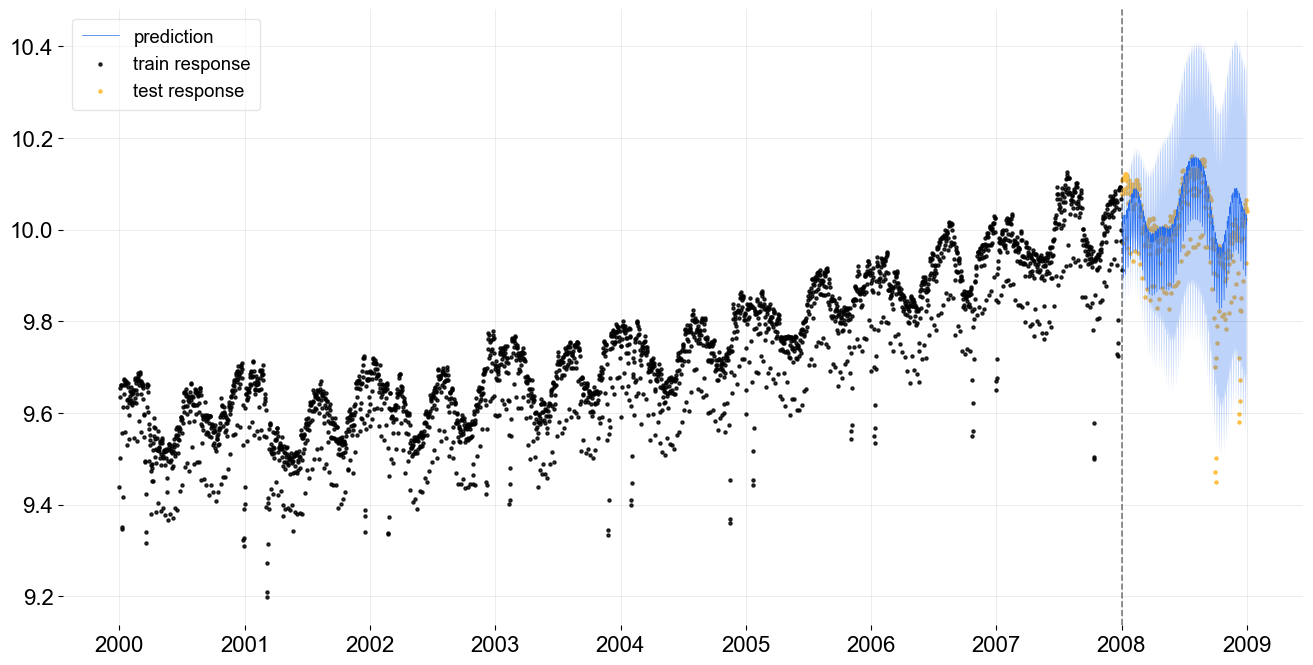

In [12]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

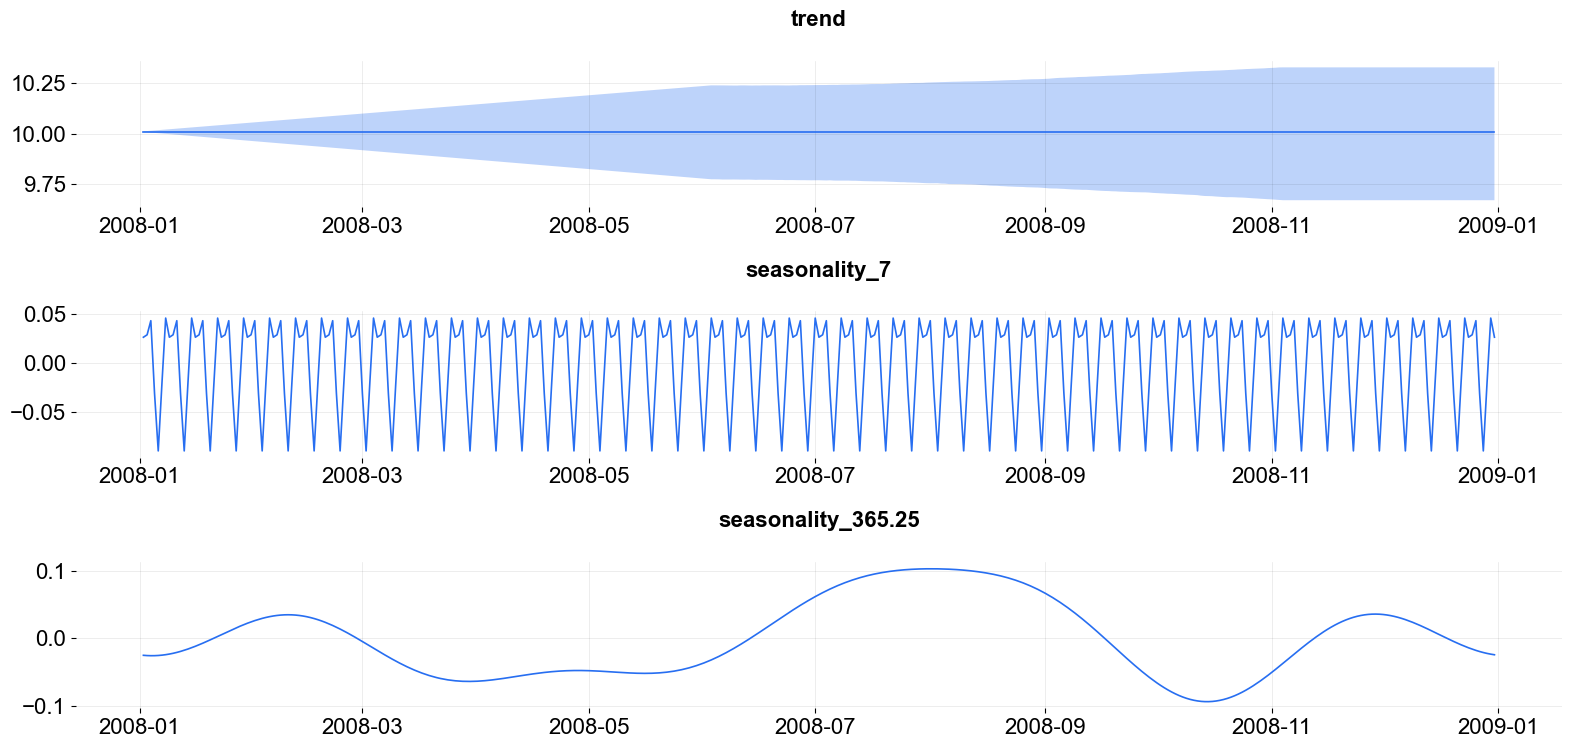

In [13]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

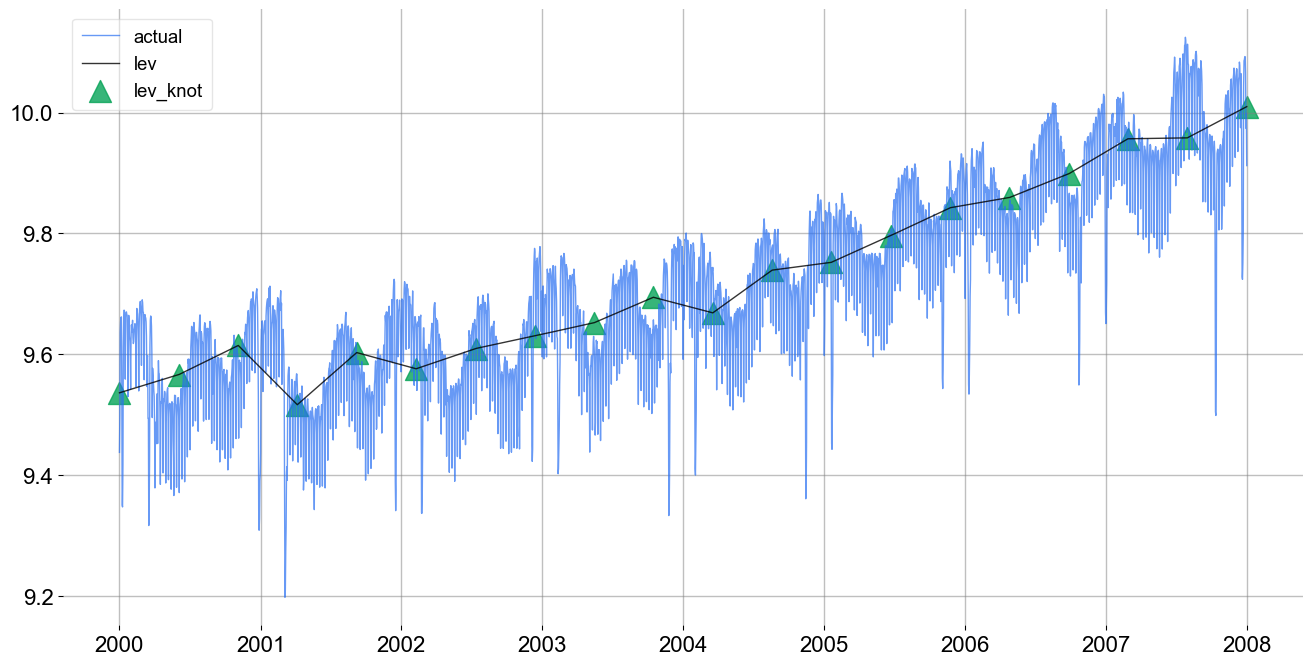

In [14]:
_ = ktrlite.plot_lev_knots()

In [15]:
ktrlite._model._level_knot_dates

array(['2000-01-01T00:00:00.000000000', '2000-06-03T00:00:00.000000000',
       '2000-11-04T00:00:00.000000000', '2001-04-06T00:00:00.000000000',
       '2001-09-07T00:00:00.000000000', '2002-02-08T00:00:00.000000000',
       '2002-07-12T00:00:00.000000000', '2002-12-13T00:00:00.000000000',
       '2003-05-15T00:00:00.000000000', '2003-10-16T00:00:00.000000000',
       '2004-03-18T00:00:00.000000000', '2004-08-19T00:00:00.000000000',
       '2005-01-19T00:00:00.000000000', '2005-06-22T00:00:00.000000000',
       '2005-11-23T00:00:00.000000000', '2006-04-26T00:00:00.000000000',
       '2006-09-27T00:00:00.000000000', '2007-02-27T00:00:00.000000000',
       '2007-07-31T00:00:00.000000000', '2008-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [16]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head()

,date,lev_knot
0,2000-01-01,9.53615
1,2000-06-03,9.56628
2,2000-11-04,9.61450
3,2001-04-06,9.51648
4,2001-09-07,9.60272


# Stability Check

### Test on different seeds

In [17]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=0,
    estimator='stan-map',
    seed=2020
)

ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=0,
    estimator='stan-map',
    seed=2021
)

ktrlite1.fit(df);
ktrlite2.fit(df);

In [18]:
np.allclose(
    ktrlite1.get_point_posteriors()['map']['lev_knot'],
    ktrlite2.get_point_posteriors()['map']['lev_knot'],
    rtol=1e-3,
)

True

### Test on different segments

In [19]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=18,
    seasonality_segments=0,
    estimator='stan-map',
)

ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=0,
    estimator='stan-map',
)

ktrlite1.fit(df);
ktrlite2.fit(df);

In [20]:
np.allclose(
    ktrlite1.get_point_posteriors()['map']['obs_scale'],
    ktrlite2.get_point_posteriors()['map']['obs_scale'],
    rtol=1e-2,
)

True

## KTR and knots utilities demo and tests

In [21]:
from orbit.utils.knots import get_knot_idx, get_knot_dates

In [22]:
# case1 use segements
date_array = train_df[DATE_COL]
print(train_df.shape[0])
knot_idx = get_knot_idx(
    num_of_obs=train_df.shape[0],
    num_of_segments=10,
)
print(knot_idx)
knot_dates = get_knot_dates(date_array[0], knot_idx, date_array[1] - date_array[0])
print(knot_dates)

2923
[   0  292  584  877 1169 1461 1753 2045 2338 2630 2922]
['2000-01-01T00:00:00.000000000' '2000-10-19T00:00:00.000000000'
 '2001-08-07T00:00:00.000000000' '2002-05-27T00:00:00.000000000'
 '2003-03-15T00:00:00.000000000' '2004-01-01T00:00:00.000000000'
 '2004-10-19T00:00:00.000000000' '2005-08-07T00:00:00.000000000'
 '2006-05-27T00:00:00.000000000' '2007-03-15T00:00:00.000000000'
 '2008-01-01T00:00:00.000000000']


In [23]:
# case2 use segements = 1
knot_idx = get_knot_idx(
    num_of_obs=train_df.shape[0],
    num_of_segments=1,
)
print(knot_idx)
knot_dates = get_knot_dates(date_array[0], knot_idx, date_array[1] - date_array[0])
print(knot_dates)

[   0 2922]
['2000-01-01T00:00:00.000000000' '2008-01-01T00:00:00.000000000']


In [24]:
# case3 use segements = 0
knot_idx = get_knot_idx(
    num_of_obs=train_df.shape[0],
    num_of_segments=0,
)
print(knot_idx)
knot_dates = get_knot_dates(date_array[0], knot_idx, date_array[1] - date_array[0])
print(knot_dates)

[0]
['2000-01-01T00:00:00.000000000']


In [25]:
# case4 use knot_distance
knot_idx = get_knot_idx(
    num_of_obs=train_df.shape[0],
    knot_distance=100,
)
print(knot_idx)
knot_dates = get_knot_dates(date_array[0], knot_idx, date_array[1] - date_array[0])
print(knot_dates)

[   0   22  122  222  322  422  522  622  722  822  922 1022 1122 1222
 1322 1422 1522 1622 1722 1822 1922 2022 2122 2222 2322 2422 2522 2622
 2722 2822 2922]
['2000-01-01T00:00:00.000000000' '2000-01-23T00:00:00.000000000'
 '2000-05-02T00:00:00.000000000' '2000-08-10T00:00:00.000000000'
 '2000-11-18T00:00:00.000000000' '2001-02-26T00:00:00.000000000'
 '2001-06-06T00:00:00.000000000' '2001-09-14T00:00:00.000000000'
 '2001-12-23T00:00:00.000000000' '2002-04-02T00:00:00.000000000'
 '2002-07-11T00:00:00.000000000' '2002-10-19T00:00:00.000000000'
 '2003-01-27T00:00:00.000000000' '2003-05-07T00:00:00.000000000'
 '2003-08-15T00:00:00.000000000' '2003-11-23T00:00:00.000000000'
 '2004-03-02T00:00:00.000000000' '2004-06-10T00:00:00.000000000'
 '2004-09-18T00:00:00.000000000' '2004-12-27T00:00:00.000000000'
 '2005-04-06T00:00:00.000000000' '2005-07-15T00:00:00.000000000'
 '2005-10-23T00:00:00.000000000' '2006-01-31T00:00:00.000000000'
 '2006-05-11T00:00:00.000000000' '2006-08-19T00:00:00.0000000

In [26]:
# case5 use knot_dates
knot_idx = get_knot_idx(
    date_array=train_df[DATE_COL],
    knot_dates=pd.to_datetime(['2003-01-01', '2005-03-31'])
)
print(knot_idx)
knot_dates = get_knot_dates(date_array[0], knot_idx, date_array[1] - date_array[0])
print(knot_dates)

[1096 1916]
['2003-01-01T00:00:00.000000000' '2005-03-31T00:00:00.000000000']
